In [2]:
!python simulation_analytical.py -d L025N752/DMONLY/SigmaConstant00/high_res_1Halo --MW_halo --no-VC_halo --no-AG_halo

From 1 to and incl. 10000
Batch 1/8 done!
From 10001 to and incl. 20000
Batch 2/8 done!
From 20001 to and incl. 30000
Batch 3/8 done!
From 30001 to and incl. 40000
Batch 4/8 done!
From 40001 to and incl. 50000
Batch 5/8 done!
From 50001 to and incl. 60000
Batch 6/8 done!
From 60001 to and incl. 70000
Batch 7/8 done!
From 70001 to and incl. 80000
Batch 8/8 done!
Sim time: 3.020980937833277 min, 0.05034968229722128 h.


In [1]:
!python simulation_numerical.py -d L025N752/DMONLY/SigmaConstant00/high_res_1Halo -st single_halos -mg 12.0 -mr 0.6 -hn 1

********Numerical Simulation: Mode=single_halos********
Halo batch params (Rvir,Mvir,cNFW):
[[253.5523526   12.24058042   6.9286026 ]]
***********************************
halo 1/1 ; snapshot 0012
halo 1/1 ; snapshot 0013
halo 1/1 ; snapshot 0014
halo 1/1 ; snapshot 0015
halo 1/1 ; snapshot 0016
halo 1/1 ; snapshot 0017
halo 1/1 ; snapshot 0018
halo 1/1 ; snapshot 0019
halo 1/1 ; snapshot 0020
halo 1/1 ; snapshot 0021
halo 1/1 ; snapshot 0022
halo 1/1 ; snapshot 0023
halo 1/1 ; snapshot 0024
halo 1/1 ; snapshot 0025
halo 1/1 ; snapshot 0026
halo 1/1 ; snapshot 0027
halo 1/1 ; snapshot 0028
halo 1/1 ; snapshot 0029
halo 1/1 ; snapshot 0030
halo 1/1 ; snapshot 0031
halo 1/1 ; snapshot 0032
halo 1/1 ; snapshot 0033
halo 1/1 ; snapshot 0034
halo 1/1 ; snapshot 0035
halo 1/1 ; snapshot 0036
***Running simulation: mode = single_halos***
halo=1/1, CPUs=128
Sim time: 18.128855064647116 min, 0.30214758441078526 h.
Total time: 76.22854264361861 min, 1.2704757107269768 h.


## Load, transform and plot simulation outputs.

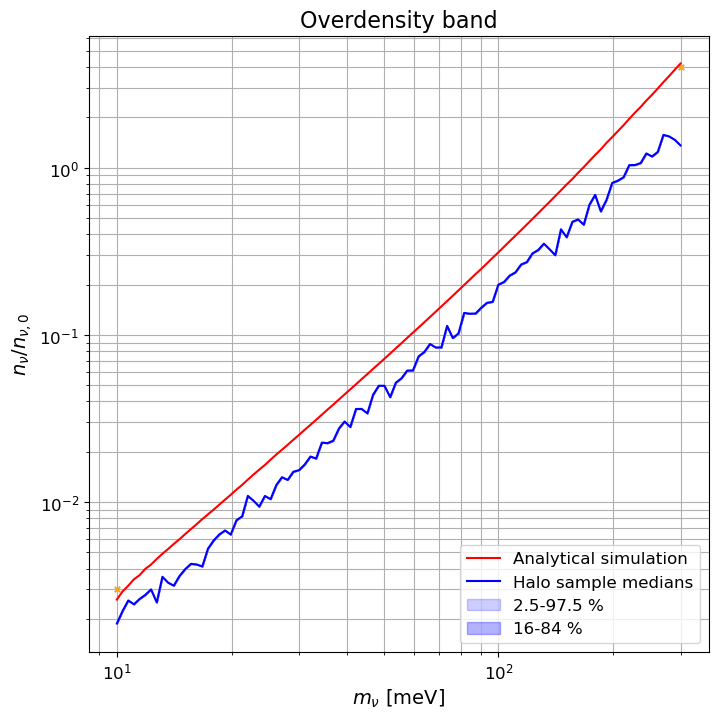

In [6]:
from shared.preface import *
from shared.shared_functions import *

def transform_simulation_outputs(out_dir, sim_type):
    """
    sim_type specifies simulation mode: 'single_halos', 'all_sky', 'spheres'.
    """

    # Try loading the equivalent output for the analytical simulation method.
    # If it hasn't been run yet, raise error and inform user.
    try:

        # Load neutrino vectors (positions and velocities) of the 10k batches, and concatenate them into a single array.
        batch_paths = glob.glob(
            f'{out_dir}/neutrino_vectors_analytical_batch*.npy'
        )
        vectors_ana = []
        for batch_path in batch_paths:
            vectors_ana.append(np.load(batch_path))
        vectors_ana = np.squeeze(np.array(vectors_ana))

        etas_ana = np.load(
            f'{out_dir}/number_densities_analytical.npy'
        )/N0

        analytical_out = True

    except FileNotFoundError:
        print('! Analytical simulation output not found !')
        analytical_out = False


    if 'single_halos' or 'spheres' in sim_type:
        
        # Load neutrino vectors (positions and velocities) of the 10k batches, and concatenate them into a single array.
        batch_paths = glob.glob(
            f'{out_dir}/neutrino_vectors_numerical_halo1_batch*.npy'
        )
        vectors_num = []
        for batch_path in batch_paths:
            vectors_num.append(np.load(batch_path))
        vectors_num = np.squeeze(np.array(vectors_num))

        etas_num = np.load(
            f'{out_dir}/number_densities_numerical_halo1.npy'
        )/N0

        if analytical_out:
            return vectors_ana, etas_ana, vectors_num, etas_num
        else:
            return vectors_num, etas_num
    
    else:
        # Load angle pairs and calculate overdensities for the all_sky mode.
        all_sky_output = np.load(f'{out_dir}/number_densities_numerical.npy')
        angle_pairs = all_sky_output[:, :2]
        etas_numerical = all_sky_output[:, 2:]/N0

        return etas_numerical, angle_pairs


def analyze_simulation_outputs(
        etas, m_nu_range, out_dir,
        plots_to_make, ylims, Mertsch=False,
        # vectors, sim_fullname,
    ):

    # Figure directory.
    fig_dir = f'figures/{out_dir}'
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)

    savefig_args = dict(
        bbox_inches='tight'
    )

    if Mertsch:
        etas_analytical = etas[0,:]
        etas_numerical = etas[1:,:]
    else:
        etas_numerical = etas[...]

    ### ================================== ###
    ### Figure of merit: overdensity band. ###
    ### ================================== ###

    fig, ax = plt.subplots(1,1)

    if 'overdensity_band' in plots_to_make:

        if Mertsch:
            # Plot smooth simulation.
            ax.plot(
                m_nu_range*1e3, (etas_analytical-1), color='red', ls='solid', 
                label='Analytical simulation'
            )

        # '''
        if etas_numerical.ndim <= 1:
            ax.plot(
                m_nu_range*1e3, (etas_numerical-1), color='blue', 
                label='medians'
            )
        else:
            nus_median = np.median(etas_numerical, axis=0)
            nus_perc2p5 = np.percentile(etas_numerical, q=2.5, axis=0)
            nus_perc97p5 = np.percentile(etas_numerical, q=97.5, axis=0)
            nus_perc16 = np.percentile(etas_numerical, q=16, axis=0)
            nus_perc84 = np.percentile(etas_numerical, q=84, axis=0)
            ax.plot(
                m_nu_range*1e3, (nus_median-1), color='blue', 
                label='Halo sample medians'
            )
            ax.fill_between(
                m_nu_range*1e3, (nus_perc2p5-1), (nus_perc97p5-1), 
                color='blue', alpha=0.2, label='2.5-97.5 %'
            )
            ax.fill_between(
                m_nu_range*1e3, (nus_perc16-1), (nus_perc84-1), 
                color='blue', alpha=0.3, label='16-84 %'
            )
        # '''

        if Mertsch:
            # Plot endpoint values from Mertsch et al.
            x_ends = [1e1, 3*1e2]
            y_ends = [3*1e-3, 4]
            ax.scatter(x_ends, y_ends, marker='x', s=15, color='orange')

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title(f'Overdensity band')
        ax.set_xlabel(r'$m_{\nu}$ [meV]')
        ax.set_ylabel(r'$n_{\nu} / n_{\nu, 0}$')
        # ax.set_ylim(ylims[0], ylims[1])
        plt.grid(True, which="both", ls="-")
        plt.legend(loc='lower right')


        plt.savefig(f'{fig_dir}/overdensity_band.pdf', **savefig_args)
        plt.show()


box_name = 'L025N752'
box_ver = 'DMONLY/SigmaConstant00'
sim_info = 'high_res_1Halo'
sim_type = 'single_halos'
out_dir = f'{box_name}/{box_ver}/{sim_info}'
vecs_ana, etas_ana, vecs_num, etas_num = transform_simulation_outputs(
    out_dir, sim_type
)
etas_combined = np.stack((etas_ana, etas_num), axis=0)

neutrino_massrange = np.load(f'{out_dir}/neutrino_massrange_eV.npy')*eV

analyze_simulation_outputs(
    etas=etas_combined, 
    m_nu_range=neutrino_massrange,
    out_dir=out_dir,
    plots_to_make=('overdensity_band', 'vels'), 
    ylims=(1e-3, 1e2),
    # ylims=(0, 1e-2),
    Mertsch=True
)